In [243]:
import numpy as np
from numpy import linalg as LA
import time as t
import matplotlib.pyplot as plt
plt.tight_layout()

def randomGaussianArray(length, mu, sigma):
    return np.random.normal(mu, sigma, length)

def randomUniformArray(length, minimum, maximum):
    return np.random.uniform(minimum, maximum,length)

def getBit(intState,i):
    return (intState >> i) & 1

def flipIJ(intState, i, j):
    iBit = getBit(intState,i)
    jBit = getBit(intState,j)
    x = iBit ^ jBit
    x = (x << i) | (x << j)
    return x ^ intState

def flipI(intState, i):
    return (1 << i) ^ intState

def binaryStateToIntegerState(binString): 
    return int(binString,2)

def integerStateToBinaryState(intState,length):
    return bin(intState)[2:].zfill(length)
    
#any amount of up/down spins
class SpinHalfChainFree:
    def __init__(self, length):
        
        self.length = length
        self.allowedIntStateBasis = np.arange(2**length)
        self.basisDimension = 2**length#len(self.allowedIntStateBasis)
        
        self.bitFlags = [0]*length
        for i in range(length): 
            self.bitFlags[i] = 2**i
        
        self.precomputeSpinZExpectationValues()
        self.createM1()
    
    def precomputeSpinZExpectationValues(self):
        self.spinZExpectationValues = -.5*np.ones((self.length,self.basisDimension))
        for i in range(self.length):
            for j in range(self.basisDimension):
                if getBit(j,i): 
                    self.spinZExpectationValues[i,j] *= -1
    
    def createM1(self):
        periodicPosition = np.exp(2j * np.pi * np.arange(self.length) / self.length)
        self.M1 = np.dot(np.transpose(self.spinZExpectationValues),periodicPosition)
    
    def createHeisenbergBaseHamiltonian(self, J):
        dim = self.basisDimension
        length = self.length
        
        ham = np.zeros((dim,dim))
        for a in range(dim):
            for i in range(length-1):
                j = (i+1)
                
                iBit = getBit(a,i)
                jBit = getBit(a,j)
                
                if iBit == jBit:
                    ham[a,a] += (J * 0.25)
                else: 
                    ham[a,a] -= (J * 0.25)
                    b = flipIJ(a,i,j)
                    ham[a,b] += (J * 0.25)
                    ham[b,a] += (J * 0.25)
        return ham

    def HeisenbergDoubleDisorderInstance(self,h): 
        dim = self.basisDimension
        length = self.length
        zExpec = self.spinZExpectationValues
    
        ax = randomUniformArray(length, -h, h)
        az = randomUniformArray(length, -h, h)
        dis = np.zeros((dim,dim))
        
        for a in range(dim):
            binStateList = zExpec[:,a]
            dis[a,a] += np.dot(binStateList,az)
            for i in range(length):
                b = flipI(a,i)
                dis[a,b] += .5*ax[i]
        return dis
    
    
    #this method won't work
    def specificHeisenbergDoubleDisorderInstance(self,harray): 
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        zExpec = self.spinZExpectationValues
    
        wi = harray
        dis = np.zeros((dim,dim))
        
        indA = 0
        for a in allowedStates:
            binStateList = zExpec[:,indA]
            dis[indA,indA] += np.dot(binStateList,wi)
            indA += 1
        return dis
    
    
    def CorrFunct(self, nsq, site1, site2):
        S1 = self.spinZExpectationValues[site1,:]
        S2 = self.spinZExpectationValues[site2,:]
        return np.dot(np.multiply(S1,S2),nsq) - np.dot(S1,nsq)*np.dot(S2,nsq)
    
    
def figure2(Lvals,hvals,dvals):
    Fvals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFree(Lvals[i])
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        M1sq = np.multiply(np.conj(chain.M1),chain.M1)
        for j in range(len(hvals)):
            for d in range(dvals[i]):
                H = Hbase + chain.HeisenbergDoubleDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for k in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,k],E[1][:,k])
                    halftop = np.dot(chain.M1,nsq)
                    Fvals[i,j] += (1 - ((halftop.real*halftop.real + halftop.imag*halftop.imag)/(np.dot(M1sq, nsq).real)))/((chain.basisDimension//3) *dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Fvals

def figure4(Lvals,hvals,dvals):
    Cvals = np.zeros((len(hvals),len(Lvals),Lvals[-1]//2))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFree(Lvals[i])
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDoubleDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,n],E[1][:,n])
                    for site in range(Lvals[i]):
                        for d in range(1,min(Lvals[i]//2+1,Lvals[i]-site)):
                            Cvals[j,i,d-1] += chain.CorrFunct(nsq,site,(site+d))/((chain.basisDimension//3)*Lvals[i]*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Cvals

def figure56(Lvals,hvals,dvals):
    Cvals = np.zeros((len(Lvals),len(hvals),1))
    Cvals = Cvals.tolist()
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFree(Lvals[i])
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDoubleDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,n],E[1][:,n])
                    for site in range(Lvals[i]//2):
                        Cvals[i][j].append(np.log(np.absolute(chain.CorrFunct(nsq,site,(site+Lvals[i]//2)))))
            del Cvals[i][j][0]
            print("h = " + str(hvals[j]) + " finished.")
    return np.array(Cvals)
    
def getEnergies(ham):
    return LA.eigvalsh(ham)

def getEnergyGaps(ham):
    eList = getEnergies(ham)
    return np.diff(eList)

def getRValues(ham):
    rValues = []
    eDiff = getEnergyGaps(ham)
    for i in range(1,len(eDiff)): 
        n = eDiff[i]
        m = eDiff[i-1]
        maximum = max(n,m)
        minimum = min(n,m)
        rValues.append(minimum/maximum)
    return rValues
        

def averageR(ham): 
    rValues = getRValues(ham)
    return np.mean(rValues)

def BipartEntangleS(Lvals, hvals, dvals):
    Svals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFree(Lvals[i])
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDoubleDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension):
                    #the matrix representation of the state indexing by the state in both halves
                    bipartMatrix = np.zeros((2**(Lvals[i]//2),2**(Lvals[i]//2)))
                    
                    #lambdas don't allow assignment so I need to create this
                    #and since bipartMatrix is created here because the length is variable,
                    #we need to create the function every time
                    def helper(x):
                        bipartMatrix[int(x[0]),int(x[1])] += x[2]
                    
                    #these maps have an index that matches with our full system basis
                    #and the values at the index are the index of the half system projection
                    Lmap = np.right_shift(chain.allowedIntStateBasis,Lvals[i]//2)
                    Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,Lvals[i]//2)
                    
                    #The next part maps the eigenstate weighting, E[1][:,n], to the position in matrix corresponding
                    #to the tuple value that represents the respective reduced subspaces for the basis element
                    #as encapsulated in Lmap and Rmap
                    np.apply_along_axis(helper,1,np.dstack((Lmap,Rmap,E[1][:,n]))[0])
                    #axis 1 is chosen because of the way np.dstack creates the tuples (np.dstack is essentially zip)
                    
                    #now we take the singular value decomposition (and square it as we had psi and want rho)
                    rho = np.linalg.svd(bipartMatrix,compute_uv=False)**2
                    #compute_uv=False means that we only get the singular values and not the other matrices
                    
                    #finally, rho ln rho gives us entanglement. Note that svd gives exclusively positive values
                    Svals[i][j] -= np.dot(rho,np.log(rho))/((chain.basisDimension)*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Svals

def BipartIPR(Lvals, hvals, dvals):
    IPRvals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        L = Lvals[i]
        chain = SpinHalfChainFree(L, L//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                #this list of disorder values will be used multiple times
                wi = randomUniformArray(L, -hvals[j], hvals[j])
                #just setting up the full chain H as usual
                H = Hbase + chain.specificHeisenbergDoubleDisorderInstance(wi)
                E = LA.eigh(H)
                #here we pick a distribution of particles on L and R that's faithful to the original
                #distribution of particles given the fixed particle number.
                initialRandConfig = chain.allowedIntStateBasis[np.random.randint(len(chain.allowedIntStateBasis))]
                ###print(integerStateToBinaryState(initialRandConfig,L))
                Linit = initialRandConfig >> L//2
                ###print(Linit)
                Rinit = initialRandConfig - (Linit << L//2)
                ####print(Rinit)
                Lparticles = 0
                Rparticles = 0
                for n in range(Lvals[i]//2):
                    if (Linit >> n)&1:
                        Lparticles +=1
                    if (Rinit >> n)&1:
                        Rparticles +=1
                #given this distribution, we now need to pick random eigenstates from each side
                chainL = SpinHalfChainFree(L//2, Lparticles)
                ###print(Lparticles)
                chainR = SpinHalfChainFree(L//2, Rparticles)
                ###print(Rparticles)
                #here you see why we need to reuse the disordered onsite field values
                HL = chainL.createHeisenbergBaseHamiltonian(1) + chainL.specificHeisenbergDoubleDisorderInstance(wi[L//2:L])
                HR = chainR.createHeisenbergBaseHamiltonian(1) + chainR.specificHeisenbergDoubleDisorderInstance(wi[0:L//2])
                EL = LA.eigh(HL)
                ER = LA.eigh(HL)
                ###print(EL[1])
                ###print(ER[1])
                ###print(chainL.basisDimension)
                ###print(chainR.basisDimension)
                Lstate = EL[1][:,np.random.randint(chainL.basisDimension)]
                Rstate = ER[1][:,np.random.randint(chainR.basisDimension)]
                
                ###print(Lstate)
                ###print(Rstate)
                
                #with a random state picked, we can now do the pullback to LR
                
                #first we do the same thing as in bipartite entanglement for finding the full -> L or R map
                Lmap = np.right_shift(chain.allowedIntStateBasis,L//2)
                ###print(Lmap)
                ###print(chainL.allowedStateIndexDictionary)
                Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,L//2)
                ###print(Rmap)
                ###print(chainR.allowedStateIndexDictionary)
                #and then map things together
                combinedState = np.zeros(chain.basisDimension)
                for n in range(chain.basisDimension):
                    tempL = chainL.allowedStateIndexDictionary[Lmap[n]]
                    tempR = chainR.allowedStateIndexDictionary[Rmap[n]]
                    if (tempL<chainL.basisDimension)&(tempR<chainR.basisDimension):
                        combinedState[n] = Lstate[tempL]*Rstate[tempR]
                
                #now we can calculate and save the IPR value
                ###print(combinedState)
                ###print(E[1])
                ###print(np.dot(combinedState,E[1]))
                ###print(sum((np.dot(combinedState,E[1]))**4))
                IPRvals[i][j] += (sum((np.dot(combinedState,E[1]))**4)*dvals[i])**(-1)
            print("h = " + str(hvals[j]) + " finished.")
    return IPRvals

def BipartEntangleSpectrum(Lvals, hvals, dvals):
    Sspect = np.zeros((len(Lvals),len(hvals),2*Lvals[-1]))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFree(Lvals[i])
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDoubleDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    #the matrix representation of the state indexing by the state in both halves
                    bipartMatrix = np.zeros((2**(Lvals[i]//2),2**(Lvals[i]//2)))
                    
                    #lambdas don't allow assignment so I need to create this
                    #and since bipartMatrix is created here because the length is variable,
                    #we need to create the function every time
                    def helper(x):
                        bipartMatrix[int(x[0]),int(x[1])] += x[2]
                    
                    #these maps have an index that matches with our full system basis
                    #and the values at the index are the index of the half system projection
                    Lmap = np.right_shift(chain.allowedIntStateBasis,Lvals[i]//2)
                    Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,Lvals[i]//2)
                    
                    #The next part maps the eigenstate weighting, E[1][:,n], to the position in matrix corresponding
                    #to the tuple value that represents the respective reduced subspaces for the basis element
                    #as encapsulated in Lmap and Rmap
                    np.apply_along_axis(helper,1,np.dstack((Lmap,Rmap,E[1][:,n]))[0])
                    #axis 1 is chosen because of the way np.dstack creates the tuples (np.dstack is essentially zip)
                    
                    #now we take the singular value decomposition (and square it as we had psi and want rho)
                    rho = np.linalg.svd(bipartMatrix,compute_uv=False)**2
                    #compute_uv=False means that we only get the singular values and not the other matrices
                    
                    #here we are comupting the average of the logs
                    Sspect[i][j][0:2*Lvals[i]] += np.log(rho[0:2*Lvals[i]])/((chain.basisDimension//3)*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Sspect

def EntangleDOS(Lvals, hvals, dvals):
    SEDOS = np.zeros((len(Lvals),len(hvals),1)).tolist()
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFree(Lvals[i])
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                EDOS = np.array([])
                H = Hbase + chain.HeisenbergDoubleDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    bipartMatrix = np.zeros((2**(Lvals[i]//2),2**(Lvals[i]//2)))
                    
                    def helper(x):
                        bipartMatrix[int(x[0]),int(x[1])] += x[2]
                        
                    Lmap = np.right_shift(chain.allowedIntStateBasis,Lvals[i]//2)
                    Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,Lvals[i]//2)
                    
                    np.apply_along_axis(helper,1,np.dstack((Lmap,Rmap,E[1][:,n]))[0])
                    
                    rho = np.linalg.svd(bipartMatrix,compute_uv=False)**2
                    EDOS = np.append(EDOS,np.log(rho[1:2*Lvals[i]]))
                    #[EDOS.append(val) for val in np.log(np.delete(rho,0)).tolist()]
            [SEDOS[i][j].append(val) for val in EDOS]
            print("h = " + str(hvals[j]) + " finished.")
    return SEDOS

In [205]:
hlist = [.2,1,2,3.5,5,8,12]
temp = t.clock()
f2 = figure2([8,10,12],hlist,[5000,500,50])
print(t.clock()-temp)
out, sub = plt.subplots(1)
sub.semilogx(hlist,f2[0],basex=5)
sub.semilogx(hlist,f2[1],basex=5)
sub.semilogx(hlist,f2[2],basex=5)
#sub.semilogx(hlist,f[3],basex=5)
#sub.semilogx(hlist,f[4],basex=5)
#sub.semilogx(hlist,f[5],basex=5)

L = 8 started.


KeyboardInterrupt: 

In [ ]:
Llist = [8,10]
temp = t.clock() 
f4 = figure4(Llist,[.5,8],[200,50])
print(t.clock()-temp)

In [ ]:
out,sub = plt.subplots(1)
sub.semilogy(np.arange(1,Llist[0]//2+1), np.absolute(np.trim_zeros(f4[0,0],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[1]//2+1), np.absolute(np.trim_zeros(f4[0,1],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[2]//2+1), np.absolute(np.trim_zeros(f4[0,2],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[3]//2+1), np.absolute(np.trim_zeros(f4[0,3],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[0]//2+1), np.absolute(np.trim_zeros(f4[1,0],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[1]//2+1), np.absolute(np.trim_zeros(f4[1,1],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[2]//2+1), np.absolute(np.trim_zeros(f4[1,2],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[3]//2+1), np.absolute(np.trim_zeros(f4[1,3],trim='b')), basey = np.e)

In [ ]:
Llist = [8,10,12]
hlist = [2,4.5,6.5,8,10,14,20,26]
dlist = [1000,300,100]
temp = t.clock()
f56 = figure56(Llist,hlist,dlist)
print(t.clock()-temp)

In [ ]:
out0,sub0 = plt.subplots(1)
sub0.hist(f56[0][0],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][1],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][2],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][3],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][4],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][5],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][6],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][7],density='true',histtype = 'step',bins = 30)
out1,sub1 = plt.subplots(1)
sub1.hist(f56[1][0],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][1],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][2],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][3],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][4],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][5],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][6],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][7],density='true',histtype = 'step',bins = 30)
out2,sub2 = plt.subplots(1)
sub2.hist(f56[2][0],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][1],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][2],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][3],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][4],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][5],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][6],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][7],density='true',histtype = 'step',bins = 30)

In [ ]:
f6 = np.zeros((len(Llist), len(hlist)))
for i in range(len(Llist)):
    for j in range(len(hlist)):
        f6[i,j] = np.std(np.divide(f56[i][j],np.average(f56[i][j])))
out, sub = plt.subplots(1)
sub.semilogx(hlist, f6[0],basex=5)
sub.semilogx(hlist, f6[1],basex=5)
sub.semilogx(hlist, f6[2],basex=5)

In [3]:
hlist = [1,2,3,5,8]
temp = t.clock()
SerbynAbanin1 = BipartEntangleS([8,10,12,14],hlist,[2000,200,20,5])
print(t.clock()-temp)

L = 8 started.
[9.18972944e-01 3.99308199e-02 2.21086909e-02 1.89590282e-02
 1.10040293e-05 8.08484635e-06 7.26015398e-06 1.82602621e-06
 1.41932022e-07 8.44890938e-08 4.73219431e-08 2.91250685e-08
 1.35086755e-08 9.41329277e-09 8.00794705e-09 7.77625524e-09]
[5.03726824e-01 2.73975842e-01 1.76946522e-01 4.48531950e-02
 3.54879410e-04 5.70827842e-05 3.29639072e-05 2.92442715e-05
 1.21670542e-05 5.70296427e-06 3.10337385e-06 7.62959805e-07
 7.50153491e-07 3.81155920e-07 3.56725255e-07 2.21619712e-07]
[6.70524820e-01 2.39915167e-01 5.64826590e-02 2.28109996e-02
 7.19695553e-03 1.68991761e-03 7.17731679e-04 5.59408001e-04
 6.66120776e-05 2.40395763e-05 5.25117996e-06 2.81505032e-06
 1.82711342e-06 1.10672149e-06 4.75442430e-07 2.14421907e-07]
[4.59106477e-01 3.30399671e-01 1.02957949e-01 8.07941724e-02
 2.21799195e-02 3.93546581e-03 3.01857059e-04 1.83176729e-04
 8.85966980e-05 2.20984808e-05 1.20480587e-05 5.75265537e-06
 4.95278979e-06 4.59957631e-06 1.65890705e-06 1.60512048e-06]
[4.42

 8.60466293e-08 3.23712432e-09 2.76799809e-09 1.47103547e-10]
[5.03587167e-01 3.06511670e-01 1.56221418e-01 1.99466899e-02
 6.13723667e-03 5.52400128e-03 1.29622049e-03 5.06434789e-04
 2.51310481e-04 1.06150678e-05 3.89709058e-06 3.33525856e-06
 3.05499952e-09 7.81943119e-11 5.83515023e-11 1.26590857e-11]
[6.04530881e-01 3.02980023e-01 6.01169481e-02 1.53510962e-02
 8.26685852e-03 8.23611083e-03 4.02842855e-04 9.11999482e-05
 1.46619756e-05 6.43212120e-06 2.23888831e-06 6.90830100e-07
 1.39943708e-08 1.26558703e-09 3.64877732e-10 1.79946529e-12]
[6.25181206e-01 2.15678410e-01 1.53048322e-01 3.28446655e-03
 2.51283268e-03 1.40190458e-04 6.92809244e-05 4.34799127e-05
 3.35961225e-05 5.44586806e-06 2.35392357e-06 4.15627085e-07
 1.56302373e-10 8.28244444e-11 2.63137829e-11 3.06822573e-12]
[9.00836166e-01 8.96849257e-02 6.93827502e-03 2.51983289e-03
 1.17380106e-05 4.27687013e-06 3.21818949e-06 1.16491361e-06
 2.38804228e-07 9.16627491e-08 4.66414945e-08 1.07826466e-08
 9.73350306e-09 3.01

[3.29401630e-01 2.63136406e-01 1.24988035e-01 6.73287261e-02
 6.48357626e-02 5.60375024e-02 5.23217596e-02 3.57757954e-02
 5.07637568e-03 3.21834313e-04 2.73974431e-04 2.05707783e-04
 2.03268257e-04 5.43073512e-05 2.10201508e-05 1.78955931e-05]
[3.98644601e-01 3.05665459e-01 1.19802822e-01 6.66173354e-02
 5.38485422e-02 2.13986796e-02 1.62639860e-02 1.24434260e-02
 3.12370054e-03 1.83305432e-03 2.01622254e-04 6.06988821e-05
 4.83720609e-05 3.25038743e-05 1.18822768e-05 3.31406014e-06]
[5.01893249e-01 3.64808006e-01 4.85168529e-02 1.97634449e-02
 1.95145420e-02 1.35712131e-02 1.17294781e-02 1.02241475e-02
 5.60901086e-03 2.51648683e-03 8.05158495e-04 6.35933903e-04
 2.70482686e-04 1.30196475e-04 8.56461805e-06 3.23328838e-06]
[2.38752788e-01 2.34740470e-01 1.92766748e-01 1.59561188e-01
 7.53077544e-02 3.16678683e-02 3.11095508e-02 2.55467107e-02
 5.32829590e-03 1.85437551e-03 1.44634054e-03 1.15461982e-03
 5.88010329e-04 1.30908244e-04 3.32508250e-05 1.11214110e-05]
[3.37397329e-01 2.64

[4.09574500e-01 2.87290770e-01 2.70041568e-01 1.62567096e-02
 1.39501440e-02 2.82764294e-03 2.53526629e-05 1.58601750e-05
 1.29051389e-05 3.97005399e-06 4.90235297e-07 7.63850860e-08
 1.03403369e-08 8.47895445e-10 4.84380627e-10 3.14222920e-11]
[4.02105905e-01 3.61777040e-01 1.57455317e-01 6.91473834e-02
 9.32342905e-03 1.47983805e-04 1.39365341e-05 1.35209881e-05
 1.12728856e-05 3.89436220e-06 2.60811938e-07 4.48049179e-08
 8.47824375e-09 2.68988519e-09 1.66563363e-10 1.87134340e-11]
[8.13348379e-01 1.50843788e-01 3.50133935e-02 5.38078607e-04
 2.47461258e-04 5.77135147e-06 2.16478282e-06 3.75979418e-07
 3.57722020e-07 1.46459399e-07 7.42998644e-08 8.83093545e-09
 7.67217161e-12 1.09508316e-12 9.59462984e-13 3.44530458e-13]
[9.05531733e-01 3.63885400e-02 2.98557832e-02 2.81970866e-02
 1.48558563e-05 6.07095412e-06 4.23242039e-06 1.43640688e-06
 1.17270164e-07 5.57051861e-08 3.88755232e-08 2.36352897e-08
 7.35771394e-09 7.11093157e-09 5.76037788e-09 5.73072033e-09]
[4.63245360e-01 3.28

 1.56137770e-05 1.44082157e-05 1.40996844e-06 2.56881468e-07]
[4.65111030e-01 2.92307352e-01 1.68831024e-01 4.41274946e-02
 2.02753978e-02 6.03869710e-03 1.22925180e-03 8.51161873e-04
 8.31541801e-04 1.35398352e-04 1.27001410e-04 8.64407879e-05
 2.89109818e-05 1.90222309e-05 2.56400268e-07 1.84115100e-08]
[4.73002043e-01 2.71140997e-01 9.67368238e-02 8.45229713e-02
 3.76681140e-02 3.33954587e-02 1.23631430e-03 8.28052277e-04
 5.72801985e-04 3.24161412e-04 2.12662839e-04 1.90762789e-04
 1.19304601e-04 3.15511016e-05 1.10136634e-05 6.96790563e-06]
[3.71114258e-01 2.30473837e-01 1.68213051e-01 1.46327543e-01
 3.83011321e-02 3.00932641e-02 9.46717835e-03 4.32912908e-03
 4.77961945e-04 4.19999681e-04 3.51979256e-04 1.25699901e-04
 1.12103258e-04 8.69790583e-05 6.25912677e-05 4.32939687e-05]
[3.08289633e-01 2.24948322e-01 1.88736999e-01 1.50180204e-01
 8.90306948e-02 1.88483132e-02 8.65326126e-03 8.23922606e-03
 1.24449515e-03 5.81691106e-04 4.56177581e-04 3.20851354e-04
 2.23698633e-04 1.03

 2.35070244e-08 1.11422323e-08 6.70540810e-09 4.95742776e-09]
[4.07066294e-01 3.81850165e-01 1.90969188e-01 1.95481877e-02
 2.80165059e-04 1.74706895e-04 4.30052105e-05 1.67278475e-05
 1.51279902e-05 1.34930302e-05 1.18976039e-05 9.25109116e-06
 1.61905190e-06 1.33163712e-07 2.87929266e-08 1.06396006e-08]
[5.89909188e-01 3.56312684e-01 2.63150874e-02 2.17913810e-02
 2.92715372e-03 2.34861005e-03 1.61325042e-04 1.42914626e-04
 6.23994916e-05 1.81476939e-05 5.20573433e-06 3.50775733e-06
 1.64320291e-06 6.14935543e-07 1.04626496e-07 3.29442273e-08]
[5.57373168e-01 2.79317557e-01 1.33230535e-01 1.03945184e-02
 8.67268129e-03 8.24032772e-03 1.31107528e-03 8.93315826e-04
 2.57218470e-04 1.37940863e-04 9.94481974e-05 6.98778838e-05
 2.12081719e-06 1.77416378e-07 2.80102522e-08 9.34732390e-09]
[4.18030550e-01 3.20431879e-01 1.75613942e-01 5.47283471e-02
 1.27578843e-02 1.25920341e-02 3.92964689e-03 1.66210243e-03
 9.83085499e-05 6.69924357e-05 3.73210707e-05 3.59043071e-05
 1.31863639e-05 1.56

[4.01838389e-01 1.84946267e-01 1.10479456e-01 9.40652818e-02
 8.85286762e-02 3.78209950e-02 2.20763051e-02 1.99451817e-02
 1.48973898e-02 1.27726907e-02 7.97362344e-03 4.18741920e-03
 3.63069809e-04 5.80543286e-05 3.36719242e-05 1.35296291e-05]
[3.18163372e-01 2.00653126e-01 1.32784791e-01 1.21344736e-01
 6.09337515e-02 5.90667234e-02 3.03975516e-02 2.97310801e-02
 1.57410780e-02 1.47928617e-02 1.11005155e-02 1.94681806e-03
 1.59417827e-03 1.11143235e-03 5.93840368e-04 4.41438670e-05]
[2.13211162e-01 1.85792212e-01 1.40908600e-01 1.17762418e-01
 9.54357312e-02 9.07050769e-02 8.74764814e-02 2.95286548e-02
 1.27312727e-02 1.21754067e-02 1.06978681e-02 2.11383001e-03
 1.28543950e-03 1.15804921e-04 5.70112903e-05 3.03004457e-06]
[2.66473463e-01 2.14368328e-01 1.41371681e-01 7.80123743e-02
 7.65690301e-02 6.78436214e-02 4.75672609e-02 3.88635285e-02
 3.03685884e-02 2.21448457e-02 1.02617586e-02 1.99276908e-03
 1.91593710e-03 1.76111398e-03 2.95447996e-04 1.90252099e-04]
[4.81645570e-01 2.18

 1.87534796e-04 9.95660339e-05 3.50057669e-05 1.31893961e-06]
[3.34887205e-01 2.10618720e-01 1.56449654e-01 1.35678240e-01
 5.62987243e-02 4.38041938e-02 2.74058480e-02 1.39614995e-02
 9.28876712e-03 7.79897724e-03 1.84424446e-03 1.19416873e-03
 5.24718710e-04 2.25811362e-04 1.46887179e-05 4.53841233e-06]
[3.13944921e-01 2.05607627e-01 1.91679734e-01 9.83556915e-02
 9.64606486e-02 5.97205460e-02 1.28149251e-02 7.95116455e-03
 6.36006012e-03 3.87403237e-03 2.92425991e-03 2.06100849e-04
 8.28575593e-05 1.08225343e-05 3.47816622e-06 3.13166265e-06]
[2.75649707e-01 2.41848362e-01 1.67822309e-01 1.24034100e-01
 7.27435871e-02 5.01120265e-02 4.09514001e-02 1.10234512e-02
 8.26456165e-03 4.22533172e-03 1.13175225e-03 1.04465400e-03
 8.31527515e-04 2.41998911e-04 4.75033148e-05 2.77288516e-05]
[4.48859483e-01 2.25578930e-01 1.15282920e-01 9.50812637e-02
 4.59245921e-02 2.41255911e-02 1.69371373e-02 1.46012347e-02
 9.13563629e-03 2.81376927e-03 1.17210923e-03 4.56964678e-04
 2.78559520e-05 1.71

[5.04142118e-01 1.76831352e-01 9.66246271e-02 5.52430483e-02
 4.49880179e-02 3.35395053e-02 3.33010919e-02 3.15457224e-02
 1.81604522e-02 3.10040995e-03 1.29394040e-03 1.22725674e-03
 1.35438335e-06 7.71324741e-07 2.88051778e-07 4.43705169e-08]
[7.25037991e-01 1.01270407e-01 6.01165421e-02 3.15120865e-02
 2.27854459e-02 1.91840104e-02 1.50729848e-02 1.12164040e-02
 7.72751521e-03 4.43178776e-03 1.27266659e-03 3.68745668e-04
 3.16513549e-06 2.35307431e-07 1.02208474e-08 1.59837636e-09]
[6.00617716e-01 1.71235560e-01 7.43659052e-02 5.94157084e-02
 3.58122905e-02 2.52396949e-02 1.91321161e-02 6.89984587e-03
 5.46648283e-03 1.04596251e-03 5.98480053e-04 1.67801733e-04
 1.41995914e-06 7.38236636e-07 2.76417292e-07 7.32876638e-10]
[5.49056777e-01 2.25597872e-01 1.03867227e-01 4.14130179e-02
 3.46171658e-02 2.68067516e-02 7.87588821e-03 4.68663632e-03
 2.90832734e-03 2.81926877e-03 2.20695825e-04 1.28195466e-04
 1.70741897e-06 4.65324966e-07 4.54167271e-09 3.95335298e-10]
[4.28611949e-01 1.80

[3.85269524e-01 1.67055313e-01 1.47769364e-01 7.94195797e-02
 6.06368580e-02 5.92702920e-02 5.90326603e-02 3.02225190e-02
 6.01603366e-03 3.46273515e-03 1.13967184e-03 2.85914031e-04
 2.30149873e-04 1.78273077e-04 8.41233034e-06 2.70037909e-06]
[3.69028311e-01 3.05433263e-01 1.03431739e-01 8.23828782e-02
 5.99947397e-02 3.73862182e-02 3.06293190e-02 4.31399153e-03
 3.58443950e-03 3.04364318e-03 6.56863037e-04 6.12529894e-05
 4.71691161e-05 6.11999727e-06 3.22800511e-08 2.01661447e-08]
[3.76516642e-01 1.60495508e-01 1.50507900e-01 1.30277191e-01
 7.59086297e-02 4.60897079e-02 3.39189922e-02 2.24471768e-02
 1.73577546e-03 9.35170897e-04 4.60322381e-04 2.88743528e-04
 2.53643214e-04 7.68416974e-05 4.66047610e-05 4.11507653e-05]
[4.26812244e-01 2.63138888e-01 1.47321637e-01 6.53269738e-02
 3.54779753e-02 2.12916462e-02 2.02163576e-02 1.54051881e-02
 2.43807695e-03 2.18208187e-03 3.14815426e-04 3.64905783e-05
 1.83390099e-05 8.24407884e-06 5.72418354e-06 5.31832029e-06]
[4.00353486e-01 1.31

 3.85124343e-05 1.47929079e-05 7.84739276e-06 1.92866663e-06]
[3.04571318e-01 1.84019957e-01 1.82299617e-01 1.00984313e-01
 9.08942094e-02 4.65801092e-02 3.93009542e-02 2.10931017e-02
 1.60863441e-02 1.10546756e-02 2.56948868e-03 2.51171039e-04
 1.36248095e-04 6.44460088e-05 5.31867912e-05 4.08602684e-05]
[3.85834700e-01 1.98686352e-01 1.65755047e-01 1.29189318e-01
 3.66503074e-02 2.87814100e-02 2.48378769e-02 1.63707944e-02
 7.94127245e-03 3.18803994e-03 1.80424171e-03 3.50476035e-04
 1.80874222e-04 1.71657401e-04 1.43006820e-04 1.14626409e-04]
[3.99945586e-01 1.96939154e-01 1.53934732e-01 1.07006024e-01
 4.19369478e-02 2.91206669e-02 2.42189684e-02 2.32077909e-02
 9.02988817e-03 6.42746923e-03 3.99977918e-03 2.07653983e-03
 1.65043737e-03 4.16244780e-04 5.73666456e-05 3.24053409e-05]
[4.73254064e-01 2.38497682e-01 8.45689446e-02 5.39712366e-02
 4.12757926e-02 3.74013827e-02 3.11859885e-02 1.83925343e-02
 1.38896416e-02 2.45966232e-03 2.42483734e-03 1.40027256e-03
 5.86363049e-04 4.49

[2.39219755e-01 1.74739872e-01 1.73306965e-01 1.28903368e-01
 8.53461436e-02 6.84851419e-02 5.55650579e-02 3.28593401e-02
 1.49811436e-02 9.68044648e-03 6.19551947e-03 6.10891505e-03
 2.70927724e-03 1.69130832e-03 1.40096532e-04 6.76499176e-05]
[3.10494714e-01 1.91855403e-01 1.29949445e-01 1.17509606e-01
 8.74524767e-02 5.35406695e-02 4.76364596e-02 2.17221064e-02
 2.05791921e-02 7.99839469e-03 7.09272535e-03 3.37261586e-03
 7.75503548e-04 2.04092855e-05 2.63252625e-07 1.65722137e-08]
[4.57561899e-01 1.68005977e-01 1.30406847e-01 8.15561705e-02
 6.33858124e-02 2.86039167e-02 2.27983861e-02 2.17423312e-02
 1.02022056e-02 7.36993787e-03 5.98286656e-03 1.38694266e-03
 8.15082249e-04 1.79611159e-04 1.77029217e-06 2.43913169e-07]
[5.18712507e-01 1.72449596e-01 1.70637679e-01 4.91417348e-02
 3.67787391e-02 2.59818845e-02 1.06076766e-02 7.47273279e-03
 4.72054503e-03 1.75171502e-03 1.36318006e-03 2.31978559e-04
 1.31377213e-04 1.67430611e-05 1.89598703e-06 1.54064768e-08]
[2.90622738e-01 1.71

 1.59329009e-06 2.41054522e-07 1.34561966e-08 3.25310814e-09]
[6.39871219e-01 2.70696024e-01 3.52078037e-02 2.04901410e-02
 1.75292427e-02 9.15802288e-03 3.07374639e-03 2.37880476e-03
 1.15169573e-03 3.43451194e-04 9.13890898e-05 8.40443888e-06
 5.44539763e-08 9.46462630e-10 9.16965626e-11 5.15898867e-11]
[5.95547449e-01 3.81184003e-01 1.38260583e-02 4.80801687e-03
 2.56577562e-03 1.83265304e-03 1.34863705e-04 5.93906987e-05
 2.47734056e-05 1.65924639e-05 2.99186275e-07 1.19344218e-07
 2.47601930e-09 1.01038528e-09 9.74335080e-10 2.73352476e-10]
[6.78344745e-01 2.84918207e-01 1.58514069e-02 1.16231590e-02
 8.93869672e-03 1.86115900e-04 5.66110254e-05 4.27828383e-05
 1.89531025e-05 9.93204151e-06 7.30525744e-06 2.07524382e-06
 5.20187635e-09 5.15167023e-09 1.35370304e-10 1.27893026e-12]
[6.44469496e-01 2.62508132e-01 8.69414302e-02 4.82310574e-03
 1.03375151e-03 1.98523080e-04 1.55842203e-05 3.88381959e-06
 3.63120188e-06 2.34043573e-06 9.70999700e-08 2.12219708e-08
 1.40401751e-09 1.23

[6.37082798e-01 1.85197030e-01 6.57902978e-02 5.27850569e-02
 1.58600883e-02 1.45169705e-02 1.34487949e-02 4.60132263e-03
 3.66810336e-03 2.67093654e-03 2.16838272e-03 9.03869667e-04
 6.37402906e-04 6.06362605e-04 6.15192429e-05 1.06428709e-06]
[3.37223313e-01 2.36845694e-01 1.60229642e-01 9.54017978e-02
 7.55173517e-02 4.26494288e-02 3.44188813e-02 8.41591569e-03
 3.16123591e-03 2.58222129e-03 1.33552897e-03 1.01777612e-03
 5.77073915e-04 4.89383729e-04 1.34739244e-04 1.72838317e-08]
[3.49312205e-01 2.33331267e-01 1.49975887e-01 8.94566176e-02
 7.54263742e-02 4.02046063e-02 2.75981626e-02 1.65294912e-02
 6.86747635e-03 5.57549051e-03 2.33756792e-03 1.57482787e-03
 1.56980769e-03 1.24233761e-04 9.43990064e-05 2.15861219e-05]
[4.69626750e-01 2.67265004e-01 9.29814053e-02 4.38396157e-02
 4.14147035e-02 3.05630361e-02 2.58227735e-02 1.13783305e-02
 1.01592393e-02 2.87389212e-03 2.64175349e-03 9.21438396e-04
 1.62756660e-04 1.50584905e-04 1.14655907e-04 8.40609418e-05]
[4.51676250e-01 4.42

[2.15215496e-01 2.08265035e-01 1.34063348e-01 1.24877168e-01
 1.21838925e-01 7.81589794e-02 5.54282174e-02 1.86503534e-02
 1.81565352e-02 9.55468578e-03 6.99456958e-03 5.05873992e-03
 1.92385020e-03 1.18465099e-03 4.76867799e-04 1.52578112e-04]
[5.29521731e-01 1.99003349e-01 9.73884162e-02 5.09144533e-02
 3.90635831e-02 3.41202662e-02 1.80371645e-02 1.69046240e-02
 6.37190988e-03 4.04804198e-03 2.08118743e-03 1.12095432e-03
 5.65403213e-04 5.30435438e-04 1.73640626e-04 1.54840093e-04]
[2.65692798e-01 1.90294196e-01 1.62304454e-01 1.05560247e-01
 8.43223874e-02 8.37133770e-02 4.00146334e-02 2.50000795e-02
 1.42906830e-02 7.73591808e-03 6.93041847e-03 6.92500591e-03
 4.21471901e-03 2.97085813e-03 2.98277004e-05 3.97260830e-07]
[4.02634883e-01 1.82734705e-01 1.70860466e-01 1.21690049e-01
 4.77432147e-02 2.14644786e-02 2.01739849e-02 1.82498793e-02
 5.85142123e-03 4.07103803e-03 1.87041057e-03 1.84768396e-03
 6.11423138e-04 1.41492486e-04 5.30999957e-05 1.77020325e-06]
[2.51456117e-01 2.47

 7.40783924e-05 2.53150799e-06 6.04404829e-07 3.46513903e-08]
[4.79386521e-01 3.16004385e-01 1.04251736e-01 3.54246531e-02
 2.79704125e-02 1.24779244e-02 1.02775903e-02 6.97406036e-03
 4.67134684e-03 1.99682178e-03 5.62666459e-04 8.26982007e-07
 6.49111342e-07 3.89522288e-07 1.16999965e-08 5.17887782e-09]
[3.26918951e-01 2.31329072e-01 2.10598439e-01 1.20475549e-01
 4.21220163e-02 3.60646777e-02 2.14110789e-02 5.08051450e-03
 2.73962931e-03 2.06743126e-03 6.41593417e-04 4.74954734e-04
 4.21573500e-05 3.39206793e-05 1.22032865e-08 2.70958551e-09]
[4.41431870e-01 2.53273060e-01 1.17740385e-01 9.93908165e-02
 5.73223093e-02 1.49278088e-02 9.16083361e-03 4.53950719e-03
 9.93545697e-04 5.89135507e-04 3.80080182e-04 2.22811943e-04
 2.13668799e-05 6.38958461e-06 7.85492944e-08 7.56511857e-10]
[5.13899723e-01 4.07768343e-01 4.98598206e-02 1.55674970e-02
 1.03607741e-02 1.16970465e-03 6.93721998e-04 4.96792003e-04
 1.45215534e-04 1.69412096e-05 1.51800359e-05 4.08562456e-06
 1.10749120e-06 1.07

[9.06177194e-01 3.99618810e-02 2.69779620e-02 2.68223866e-02
 3.63282831e-05 1.52029759e-05 5.13725761e-06 3.31555404e-06
 2.64812741e-07 1.12672302e-07 9.03360577e-08 6.06342149e-08
 2.56000951e-08 1.58472059e-08 1.21366386e-08 1.07402452e-08]
[4.61586862e-01 2.58464031e-01 2.37622873e-01 4.18565980e-02
 2.56532520e-04 1.08264913e-04 4.45305441e-05 3.31626192e-05
 8.70943011e-06 8.51893488e-06 3.71273334e-06 3.34790022e-06
 2.49565047e-06 2.25896363e-07 8.65337114e-08 4.78357048e-08]
[6.46361854e-01 1.82989001e-01 1.06441855e-01 5.29024780e-02
 9.36388931e-03 9.93792121e-04 5.06014289e-04 3.02577706e-04
 7.55980139e-05 2.58550711e-05 1.70343622e-05 9.04594650e-06
 8.26581807e-06 1.85305647e-06 5.83480208e-07 3.03023903e-07]
[5.42174093e-01 3.76085916e-01 4.36505915e-02 2.62516653e-02
 9.16381204e-03 1.67233500e-03 6.64988743e-04 1.94498171e-04
 9.27013432e-05 2.58278734e-05 1.12095703e-05 8.84416083e-06
 2.68195396e-06 5.71658693e-07 1.77335892e-07 8.68379984e-08]
[4.79302943e-01 2.19

[5.58831427e-01 1.77589656e-01 8.74539155e-02 6.31161236e-02
 3.33456053e-02 2.36094251e-02 1.99436931e-02 1.68983115e-02
 8.32699667e-03 4.45795414e-03 3.67361679e-03 1.94529163e-03
 4.74406902e-04 3.14924139e-04 1.77622487e-05 8.90168241e-07]
[2.61460313e-01 2.14183885e-01 1.92698415e-01 1.84044746e-01
 3.31898077e-02 3.04632484e-02 2.75317903e-02 2.01506577e-02
 1.61629994e-02 1.37349256e-02 3.96212020e-03 2.00107228e-03
 3.00936636e-04 4.96137203e-05 4.22812208e-05 2.31885331e-05]
[4.07341635e-01 1.79639601e-01 1.14504617e-01 1.12621783e-01
 7.84055932e-02 2.92721838e-02 2.62180430e-02 2.53248013e-02
 1.42078609e-02 9.63390748e-03 1.60221489e-03 8.89191565e-04
 1.89045389e-04 9.48087801e-05 5.33858112e-05 1.32822671e-06]
[5.34356038e-01 1.69432531e-01 1.20811332e-01 8.06389585e-02
 6.45818542e-02 9.53452984e-03 8.16565098e-03 4.34536194e-03
 4.17629914e-03 1.87100426e-03 9.70215989e-04 6.33490489e-04
 3.77050823e-04 9.82454379e-05 5.80636647e-06 1.63103573e-06]
[2.60341399e-01 2.17

KeyboardInterrupt: 

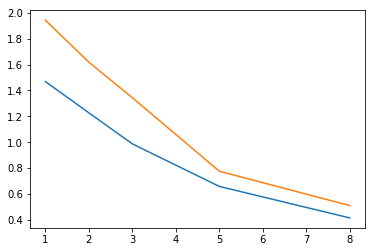

In [40]:
out,sub = plt.subplots(1)
sub.plot(hlist,SerbynAbanin1[0])
sub.plot(hlist,SerbynAbanin1[1])
#sub.plot(hlist,SerbynAbanin1[2])
#sub.plot(hlist,SerbynAbanin1[3])

In [9]:
hlist = [1,2,3,5,8]
temp = t.clock()
SerbynAbanin2 = BipartIPR([8,10,12,14],hlist,[20000,2000,200,20])
print(t.clock()-temp)

L = 8 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 10 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 12 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 14 started.


KeyboardInterrupt: 

NameError: name 'SerbynAbanin2' is not defined

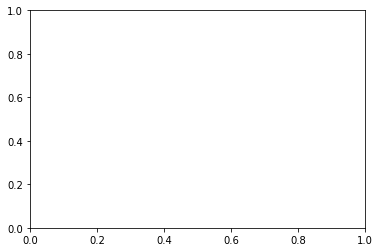

In [7]:
out,sub = plt.subplots(1)
sub.semilogy(hlist,SerbynAbanin2[0],basey=10)
sub.semilogy(hlist,SerbynAbanin2[1],basey=10)
sub.semilogy(hlist,SerbynAbanin2[2],basey=10)
sub.semilogy(hlist,SerbynAbanin2[3],basey=10)

In [254]:
hlist = [4]
temp = t.clock()
SerbynAbanin3 = BipartEntangleSpectrum([8,10,12],hlist,[1000,100,10])
print(t.clock()-temp)

L = 8 started.
h = 4 finished.
L = 10 started.
h = 4 finished.
L = 12 started.
h = 4 finished.
791.2583345308085


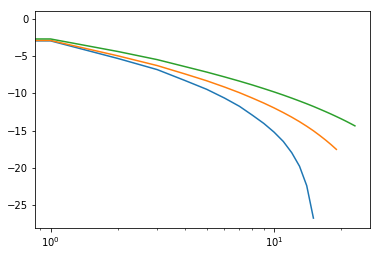

In [255]:
out,sub = plt.subplots(1)
sub.semilogx(np.trim_zeros(SerbynAbanin3[0][0]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[1][0]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[2][0]))
#sub.semilogx(np.trim_zeros(SerbynAbanin3[3][0]))

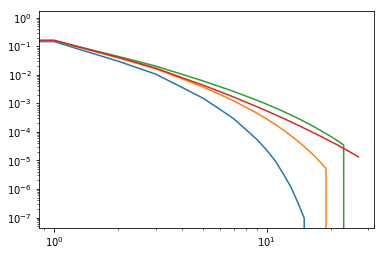

In [48]:
out,sub = plt.subplots(1)
sub.semilogx(np.trim_zeros(SerbynAbanin3[0][1]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[1][1]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[2][1]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[3][1]))

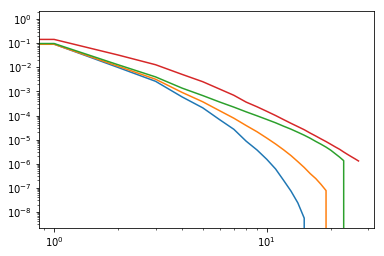

In [47]:
out,sub = plt.subplots(1)
sub.semilogx(np.trim_zeros(SerbynAbanin3[0][2]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[1][2]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[2][2]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[3][2]))

In [ ]:
hlist = [2,4,8]
temp = t.clock()
Nandkishore2017 = EntangleDOS([8,10,12,14],hlist,[1200,500,250,50])
print(t.clock()-temp)

L = 8 started.
h = 2 finished.
h = 4 finished.
h = 8 finished.
L = 10 started.
h = 2 finished.
h = 4 finished.
h = 8 finished.
L = 12 started.
h = 2 finished.
h = 4 finished.
h = 8 finished.
L = 14 started.


C:\Users\Urrburr\Anaconda3\lib\site-packages\ipykernel_launcher.py:377: RuntimeWarning: divide by zero encountered in log


(array([0.00033352, 0.00100057, 0.00200114, 0.00300171, 0.00433581,
        0.00900514, 0.00800457, 0.01033924, 0.01667619, 0.02634838,
        0.0336859 , 0.05369733, 0.0730417 , 0.1010577 , 0.13074131,
        0.14308169, 0.15508855, 0.16442721, 0.16209255, 0.15942436,
        0.16376017, 0.1544215 , 0.14374874, 0.13707827, 0.11206398,
        0.10172475, 0.06870589, 0.02167904, 0.00033352, 0.00033352]),
 array([-13.88095901, -13.41826038, -12.95556174, -12.49286311,
        -12.03016448, -11.56746584, -11.10476721, -10.64206858,
        -10.17936994,  -9.71667131,  -9.25397267,  -8.79127404,
         -8.32857541,  -7.86587677,  -7.40317814,  -6.94047951,
         -6.47778087,  -6.01508224,  -5.5523836 ,  -5.08968497,
         -4.62698634,  -4.1642877 ,  -3.70158907,  -3.23889044,
         -2.7761918 ,  -2.31349317,  -1.85079453,  -1.3880959 ,
         -0.92539727,  -0.46269863,   0.        ]),
 <a list of 1 Patch objects>)

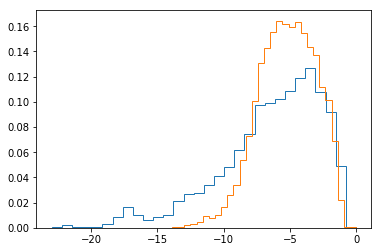

In [250]:
out,sub = plt.subplots(1)
sub.hist(Nandkishore2017[0][0], density = True, histtype = 'step', bins = 30)
sub.hist(Nandkishore2017[1][0], density = True, histtype = 'step', bins = 30)
#sub.hist(Nandkishore2017[2][0], density = True, histtype = 'step', bins = 50)

(array([0.00101523, 0.00033841, 0.00084603, 0.00203047, 0.00321491,
        0.00490696, 0.00744504, 0.0093063 , 0.01370565, 0.01928943,
        0.03079541, 0.04331662, 0.05702227, 0.07106633, 0.08409515,
        0.08511039, 0.08477198, 0.08375674, 0.07851137, 0.06971268,
        0.06615937, 0.05905273, 0.05126928, 0.04247059, 0.03756363,
        0.0275805 , 0.03181064, 0.01895102, 0.01065995, 0.00067682]),
 array([-27.36098119, -26.44894849, -25.53691578, -24.62488307,
        -23.71285037, -22.80081766, -21.88878495, -20.97675225,
        -20.06471954, -19.15268684, -18.24065413, -17.32862142,
        -16.41658872, -15.50455601, -14.5925233 , -13.6804906 ,
        -12.76845789, -11.85642518, -10.94439248, -10.03235977,
         -9.12032706,  -8.20829436,  -7.29626165,  -6.38422895,
         -5.47219624,  -4.56016353,  -3.64813083,  -2.73609812,
         -1.82406541,  -0.91203271,   0.        ]),
 <a list of 1 Patch objects>)

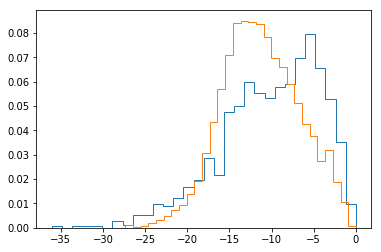

In [249]:
out,sub = plt.subplots(1)
sub.hist(Nandkishore2017[0][1], density = True, histtype = 'step', bins = 30)
sub.hist(Nandkishore2017[1][1], density = True, histtype = 'step', bins = 30)
#sub.hist(Nandkishore2017[2][1], density = True, histtype = 'step', bins = 50)

(array([0.00012528, 0.00012528, 0.00087693, 0.00062638, 0.00200442,
        0.00638908, 0.01064846, 0.02292551, 0.03044208, 0.04735434,
        0.0575017 , 0.06176109, 0.06714795, 0.06539409, 0.06752378,
        0.05687532, 0.05349287, 0.04159164, 0.04422244, 0.03683115,
        0.03369925, 0.01904196, 0.01478257, 0.01315398, 0.01140012,
        0.02330134, 0.01064846, 0.00689018, 0.00413411, 0.00087693]),
 array([-36.955429  , -35.72358137, -34.49173373, -33.2598861 ,
        -32.02803847, -30.79619083, -29.5643432 , -28.33249557,
        -27.10064793, -25.8688003 , -24.63695267, -23.40510503,
        -22.1732574 , -20.94140977, -19.70956213, -18.4777145 ,
        -17.24586687, -16.01401923, -14.7821716 , -13.55032397,
        -12.31847633, -11.0866287 ,  -9.85478107,  -8.62293343,
         -7.3910858 ,  -6.15923817,  -4.92739053,  -3.6955429 ,
         -2.46369527,  -1.23184763,   0.        ]),
 <a list of 1 Patch objects>)

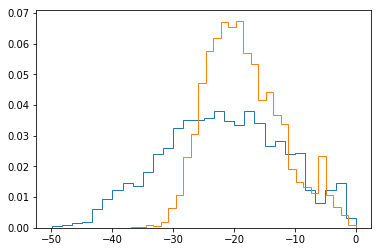

In [252]:
out,sub = plt.subplots(1)
sub.hist(Nandkishore2017[0][2], density = True, histtype = 'step', bins = 30)
sub.hist(Nandkishore2017[1][2], density = True, histtype = 'step', bins = 30)
#sub.hist(Nandkishore2017[2][2], density = True, histtype = 'step', bins = 50)